In [1]:
import spacy
import math
from spacytextblob.spacytextblob import SpacyTextBlob
import numpy as np
import pandas as pd
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

/Users/gokberk/miniconda3/envs/ml4hc_project2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gokberk/miniconda3/envs/ml4hc_project2/lib/python3.9/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.5.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### EXTRACTION

In [2]:
tables_path = 'tables/tables_52_88/'

doc_df = pd.read_csv(tables_path+'doc.csv')
id_to_text_list = doc_df['id_to_text'].values
free_text_list = doc_df['text'].values

In [5]:
entity_sent_dict = {}

unwanted_entities = ['DATE','TIME','QUANTITY','ORDINAL','CARDINAL','MONEY','PERCENT','PERSON']

for idx,text in enumerate(tqdm(free_text_list)):
    if not(isinstance(text, float) and math.isnan(text)): # check if NaN

        doc = nlp(text)
        temp_id_to_text = doc_df.iloc[idx].id_to_text

        for sent in doc.sents:
            adj_count = 0
            adj_polarity_sum = 0.0
            adj_subjectivity_sum = 0.0

            sentence_named_entities = []
            entity_chunk = None #(entity,type)

            for token in sent:

                if token.ent_iob_ == 'O':
                    if entity_chunk:
                        sentence_named_entities.append(entity_chunk)
                        entity_chunk = None
                    if token.pos_ == 'ADJ' and token._.blob.polarity!= 0.0:
                        adj_count += 1
                        adj_polarity_sum += token._.blob.polarity
                        adj_subjectivity_sum += token._.blob.subjectivity
                        
                elif token.ent_iob_ == 'B':
                    if entity_chunk:
                        sentence_named_entities.append(entity_chunk)
                        entity_chunk = None
                    entity_chunk = (token.text,token.ent_type_)
                else:
                    entity_chunk_text = entity_chunk[0]
                    entity_chunk_type = entity_chunk[1]
                    entity_chunk = (entity_chunk_text+' '+token.text,entity_chunk_type)
            
            if adj_count>0:
                sentence_avg_polarity = round(adj_polarity_sum/adj_count,4)
                sentence_avg_subj = round(adj_subjectivity_sum/adj_count,4)

                for temp_ne in sentence_named_entities:
                    if temp_ne[1] not in unwanted_entities: # if named entity type is valid
                        if entity_sent_dict.get((temp_ne[0],temp_id_to_text),None) is None:
                            entity_sent_dict[(temp_ne[0],temp_id_to_text)] = {'pol':[sentence_avg_polarity],
                                                                            'sub':[sentence_avg_subj]}
                        else:
                            entity_sent_dict[(temp_ne[0],temp_id_to_text)]['pol'].append(sentence_avg_polarity)
                            entity_sent_dict[(temp_ne[0],temp_id_to_text)]['sub'].append(sentence_avg_subj)

100%|██████████| 88016/88016 [2:51:02<00:00,  8.58it/s]   


In [6]:
entity_sent_df = pd.DataFrame(entity_sent_dict).transpose()
entity_sent_df.reset_index(inplace=True)
entity_sent_df.rename(columns={'level_0':'named_entity',
                               'level_1':'id_to_text'}, inplace=True)
entity_sent_df.to_parquet(tables_path+'entity_sentiment.parquet')

### ANALYSIS

In [2]:
import pandas as pd

entity_sent_df = pd.read_csv('tables/tables_69_76/entity_sentiment_69_76.csv')
entity_sent_df[entity_sent_df['cnt']>20].sort_values(by='pol',ascending=False)[:60]

,Unnamed: 0,pol,sub,cnt
6356,IWY,0.3467,0.5725,49.0
14931,F–14,0.3383,0.5832,25.0
689,Salzburg,0.3354,0.6012,21.0
4009,Hangchow,0.3349,0.5493,21.0
9498,Canberra,0.3187,0.5074,22.0
406,Democrat,0.3071,0.6106,37.0
15714,Uruguayans,0.3064,0.5446,22.0
3974,the Albanian Resolution,0.3054,0.5890,45.0
466,Khrushchev ’s,0.3007,0.5554,23.0
12709,Imperial Majesty,0.2963,0.5410,31.0


In [8]:
from sklearn.preprocessing import StandardScaler,MaxAbsScaler,MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [9]:
temp_df = entity_sent_df.reset_index(drop=False)
temp_df.rename(columns={'index':'y'},inplace=True)
temp_df = temp_df[temp_df['cnt']>200]

In [10]:
y = temp_df['y'].values
X = temp_df[['pol','cnt']].values
X[:,1] = np.log10(X[:,1])

In [11]:
X[:,0] = MaxAbsScaler().fit_transform(X[:,0].reshape(-1,1))[:,0]
X[:,1] = MinMaxScaler().fit_transform(X[:,1].reshape(-1,1))[:,0]

In [12]:
kmeans = KMeans(n_clusters=4)
y_pred = kmeans.fit_predict(X)

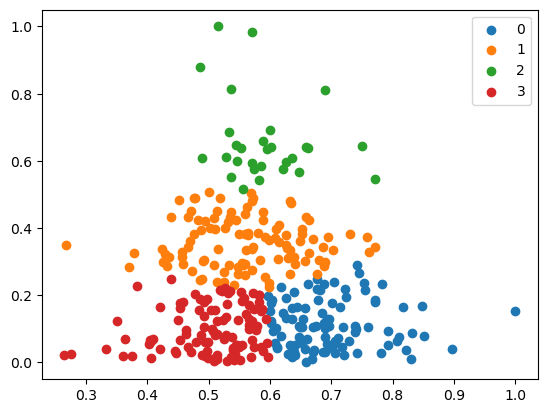

In [13]:
for label in np.unique(y_pred):
    plt.scatter(X[y_pred==label, 0] , X[y_pred==label,1], label=label)

plt.legend()

In [14]:
label_df = pd.DataFrame(data={'name':y,'label':y_pred})

In [24]:
label_df[label_df['label']==3]['name'].values

array(['Caribbean', 'Bolivia', 'Politburo', 'Navy', 'Jordanian',
       'U.S.-Soviet', 'National Security Affairs', 'Allies', 'South Asia',
       'MFN', 'Algerian', 'Commerce', 'East - West', 'West Pakistan',
       'Pakistani', 'U.K.', 'CSCE', 'Mediterranean', 'NSSM',
       'The Soviet Union', 'Turks', 'West Germany', 'ICBMs', 'Libyan',
       'Baghdad', 'South', 'Eastern', 'DMZ', 'South Viet - Nam',
       'Socialist', 'Treaty', 'Parliament', 'Syrian', 'Canal', 'Army',
       'Canadian', 'North Korean', 'Iraqis', 'PRG', 'Alliance',
       'the Department of Defense', 'North Korea', 'SC', 'Rhodesia',
       'Portuguese', 'South Africa', 'AID', 'Council', 'London',
       'Somalia', 'Indian Ocean', 'Nigeria', 'Zaire', 'Marxist', 'MAP',
       'Cubans', 'Brazilian', 'Nigerian', 'Western European', 'COCOM',
       'GATT', 'Yugoslav', 'Community', 'OECD', 'Viet - Nam', 'Cambodian',
       'Allied', 'States', 'Kenya', 'Italian', 'Athens', 'GOG', 'King',
       'Lebanon', 'Socialists', 'G